In [1]:
import numpy as np
import pickle
from geopy.distance import geodesic # used to be vincenty
import os
import math
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
from sklearn.neighbors import BallTree
import pandas as pd


os.chdir(r'/home/jupyter/Combined Trajectory_Label_Geolife')

In [43]:
A = math.degrees(-math.pi)
# Change the current working directory to the location of 'Combined Trajectory_Label_Geolife' folder.
#filename = '../Combined Trajectory_Label_Geolife/Revised_Trajectory_Label_Array.pickle'
with open('Revised_Trajectory_Label_Array.pickle', 'rb') as f:
    Trajectory_Label_Array = pickle.load(f)

In [45]:
len(Trajectory_Label_Array)
NoPoints=0
for i in range(len(Trajectory_Label_Array)):
    NoPoints+=len(Trajectory_Label_Array[i])
print(NoPoints)    

5494725


In [46]:
# Identify the Speed and Acceleration limit
SpeedLimit = {0: 7, 1: 12, 2: 120./3.6, 3: 180./3.6, 4: 120/3.6}
# Online sources for Acc: walk: 1.5 Train 1.15, bus. 1.25 (.2), bike: 2.6, train:1.5
AccLimit = {0: 3, 1: 3, 2: 2, 3: 10, 4: 3}
# Choose based on figure visualization for JerkP:{0: 4, 1: 4, 2: 4, 3: 11, 4: 6}
JerkLimitP = {0: 40, 1: 40, 2: 40, 3: 110, 4: 60}
# Choose based on figure visualization for JerkN:{0: -4, 1: -4, 2: -2.5, 3: -11, 4: -4}
JerkLimitN = {0: -40, 1: -40, 2: -200.5, 3: -110, 4: -40}

In [47]:
# Total_Instance_InSequence checks the number of GPS points for each instance in all users
Total_Instance_InSequence = []
# Total_Motion_Instance: each element is an array include the four channels for each instance
Total_Motion_Instance = []
# Save the 4 channels for each user separately
Total_RelativeDistance = []
Total_Speed = []
Total_Acceleration = []
Total_Jerk = []
Total_BearingRate = []
Total_Label = []
Total_InstanceNumber = []
Total_Outlier = []
Total_Descriptive_Stat = []
Total_Delta_Time = []
Total_Velocity_Change = []
Total_BusLine = []
Total_Railway = []
Total_Traffic = []


In [49]:
for z in range(len(Trajectory_Label_Array)):
    Data = Trajectory_Label_Array[z]
    for i in range(len(Data) - 1):
        a=Data[i, 0]
        if a> 70:
            Data[i, 0]=Data[i, 0]-360
            print(z,i)
        elif a< 0:
            print(z,i)

1 46255
1 68253


## Loading Transportation Networks' GIS Data

In [2]:
#Loading shp stops
busLine_gdf = gpd.read_file("../GIS/BeijingBusLines.shp")
busLine_gdf.set_crs(epsg=4326, inplace=True)

busbbox= busLine_gdf.envelope
busbbox= gpd.GeoDataFrame(gpd.GeoSeries(busbbox), columns=['geometry'])

<AxesSubplot:>

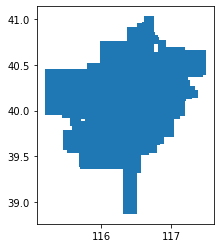

In [3]:
busbbox.plot()

In [4]:
#Creating bbox around BCL data and China
from shapely.geometry import Point, Polygon
p2 = Polygon([(75, 18.249901), (75, 58.765492), (145, 58.765492), (145, 18.)])
g = gpd.GeoSeries([p2])
bbox = gpd.GeoDataFrame(gpd.GeoSeries(g), columns=['geometry'])
bbox.set_crs(epsg=4326, inplace=True)

,geometry
0,"POLYGON ((75.00000 18.24990, 75.00000 58.76549..."


In [5]:
busbbox_difference = gpd.overlay(bbox, busbbox, how='difference')

<AxesSubplot:>

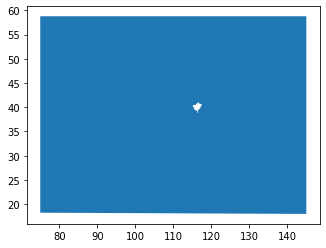

In [6]:
busbbox_difference.plot()

In [7]:
busStop_B_gdf = gpd.read_file("../GIS/BeijingBusStops.shp")
busStop_B_gdf.set_crs(epsg=4326, inplace=True)

,stationNum,name,line,geometry
0,1,³ÇÌúÁø·¼Õ¾,104Â·¿ì³µ,POINT (116.43109 39.95948)
1,2,Áø·¼±±½Ö,104Â·¿ì³µ,POINT (116.43692 39.95960)
2,3,¹ú¼ÊÕ¹ÀÀÖÐÐÄ,104Â·¿ì³µ,POINT (116.44078 39.95965)
3,4,¾²°²×¯,104Â·¿ì³µ,POINT (116.44958 39.96077)
4,5,¾²°²Àï,104Â·¿ì³µ,POINT (116.44530 39.95608)
...,...,...,...,...
42156,5,ÍÍµè´å,×¨Ïß38Â·¸ß·å,POINT (116.21500 40.06817)
42157,6,ÈýÐÇ×¯ÄÏ¿Ú,×¨Ïß38Â·¸ß·å,POINT (116.19011 40.06841)
42158,7,ÈýÐÇ×¯,×¨Ïß38Â·¸ß·å,POINT (116.18689 40.07685)
42159,8,ËÕÒ»¶þ´å,×¨Ïß38Â·¸ß·å,POINT (116.18399 40.08542)


In [ ]:
#Loading OSM data
trafficStop_gdf = gpd.read_file("../GIS/gis_osm_traffic_free_1.shp",bbox=bbox,crs='EPSG:4326')
trafficStop_gdf=trafficStop_gdf[(trafficStop_gdf.fclass=="crossing")|(trafficStop_gdf.fclass=="motorway_junction")|(trafficStop_gdf.fclass=="traffic_signals")]

railStop_gdf = gpd.read_file("../GIS/gis_osm_transport_free_1.shp",bbox=bbox,crs='EPSG:4326')
railStop_gdf=railStop_gdf[(railStop_gdf.fclass=="railway_station")|(railStop_gdf.fclass=="railway_halt")]

In [60]:
busStop_gdf = gpd.read_file("../GIS/gis_osm_transport_free_1.shp",mask=busbbox_difference,crs='EPSG:4326')
busStop_gdf=busStop_gdf[(busStop_gdf.fclass=="bus_stop")|(busStop_gdf.fclass=="bus_station")]

In [62]:
busStop_final=busStop_B_gdf.append(busStop_gdf)

<AxesSubplot:>

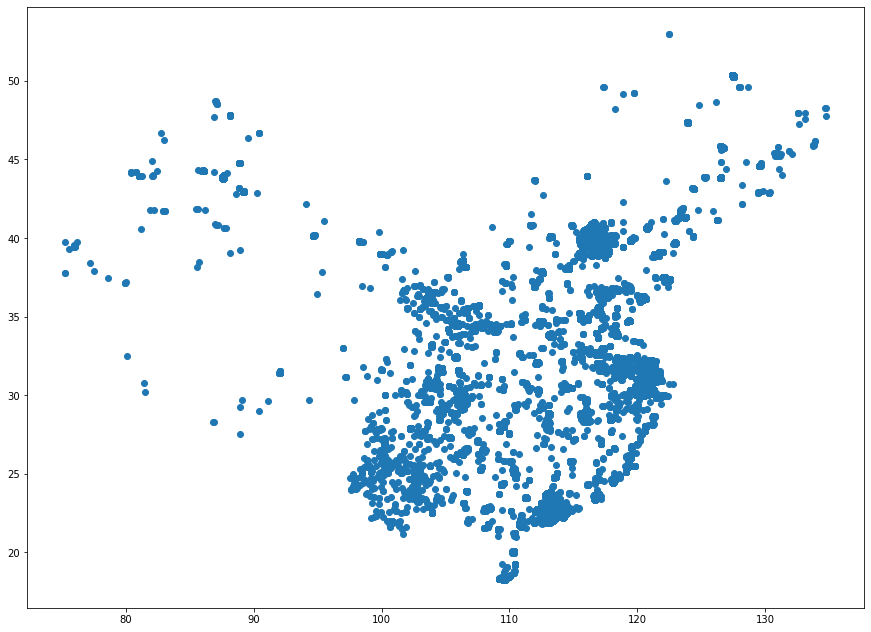

In [64]:
busStop_final.plot(figsize=[15,15])

In [65]:
#Establishing function to calculate the nearest neighbour point using the Ball Tree algorithm
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format 
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points


In [66]:
%%time
#Calculate the nearest neighbour point on the three networks for every point
RailStop_dis=[]
TrafficStop_dis=[]
BusStop_dis=[]
for z in range(2,3):#len(Trajectory_Label_Array[2])
    print(z)
    Data = Trajectory_Label_Array[z]
    if len(Data) == 0:
        BusStop_dis.append(np.array([]))
        TrafficStop_dis.append(np.array([]))
        RailStop_dis.append(np.array([]))
        continue
    arr1lat = np.ravel(Trajectory_Label_Array[z][:,0])
    arr1lon = np.ravel(Trajectory_Label_Array[z][:,1])
    df1 = pd.DataFrame({'lat':arr1lat, 'lon':arr1lon})
    df1['coords'] = list(zip( df1['lon'],df1['lat']))
    df1['coords'] = df1['coords'].apply(Point)
    gdf1 = gpd.GeoDataFrame(df1, geometry='coords')
    
    closest_stops_bus = nearest_neighbor(gdf1 ,busStop_final, return_dist=True)
    closest_stops_traffic = nearest_neighbor(gdf1 ,trafficStop_gdf, return_dist=True)
    closest_stops_rail = nearest_neighbor(gdf1 ,railStop_gdf, return_dist=True)
    
    bus_dis = closest_stops_bus['distance'].values
    traffic_dis = closest_stops_traffic['distance'].values
    rail_dis = closest_stops_rail['distance'].values
    
    BusStop_dis.append(bus_dis)
    TrafficStop_dis.append(traffic_dis)
    RailStop_dis.append(rail_dis)

2
CPU times: user 8.63 s, sys: 331 µs, total: 8.63 s
Wall time: 8.63 s


In [68]:
%%time
#Szymon's Version
# Count the number of times that NoOfOutlier happens
NoOfOutlier = 0
for z in range(2,3):# iterate of users 69 ##len(Trajectory_Label_Array)
    print(z)
    Descriptive_Stat = []
    Data = Trajectory_Label_Array[z]
    BusData=BusStop_dis[0]
    RailData=RailStop_dis[0]
    TrafficData=TrafficStop_dis[0]
    if len(Data) == 0:
        continue

    Shape = np.shape(Trajectory_Label_Array[z])
    # InstanceNumber: Break a user's trajectory to instances. Count number of GPS points for each instance
    delta_time = []
    tempSpeed = []# list with speed between two consecutive points
    for i in range(len(Data) - 1):
        delta_time.append((Data[i+1, 2] - Data[i, 2]) * 24. * 60*60)
        if delta_time[i] == 0:
            # Prevent to generate infinite speed. So use a very short time = 0.1 seconds.
            delta_time[i] = 0.1
        A = (Data[i, 0], Data[i, 1])# starting position
        B = (Data[i + 1, 0], Data[i + 1, 1])# end position
        tempSpeed.append(geodesic(A, B).meters/delta_time[i]) #speed between two consecutive points
    # Since there is no data for the last point, we assume the delta_time as the average time in the user guide
    # (i.e., 3 sec) and speed as tempSpeed equal to last time so far.
    delta_time.append(3)
    tempSpeed.append(tempSpeed[len(tempSpeed) - 1])

    # InstanceNumber: indicate the length of each instance
    InstanceNumber = []
    # Label: For each created instance, we need only one mode to be assigned to.
    # Remove the instance with less than 10 GPS points. Break the whole user's trajectory into trips with min_trip
    # Also break the instance with more than threshold GPS points into more instances
    Data_All_Instance = []  # Each of its element is a list that shows the data for each instance (lat, long, time)
    Bus_All_Instance=[]
    Rail_All_Instance=[]
    Traffic_All_Instance=[]
    Label = []
    min_trip_time = 20 * 60  # 20 minutes equal to 1200 seconds
    threshold = 200  # fixed of number of GPS points for each instance
    i = 0
    while i <= (len(Data) - 1):
        No = 0
        ModeType = Data[i, 3]
        Counter = 0
        # index: save the instance indices when an instance is being created and concatenate all in the remove
        index = []
        # First, we always have an instance with one GPS point.
        while i <= (len(Data) - 1) and Data[i, 3] == ModeType and Counter < threshold:
            if delta_time[i] <= min_trip_time:
                Counter += 1
                index.append(i)
                i += 1
            else:
                Counter += 1
                index.append(i)
                i += 1
                break

        if Counter >= 10:  # Remove all instances that have less than 10 GPS points# I
            InstanceNumber.append(Counter)
            Data_For_Instance = [Data[i, 0:3] for i in index]
            Data_For_Instance = np.array(Data_For_Instance, dtype=float)
            Data_All_Instance.append(Data_For_Instance)            
            
            Bus_For_Instance=[BusData[i] for i in index]
            Bus_All_Instance.append(Bus_For_Instance)
            
            Rail_For_Instance=[RailData[i] for i in index]
            Rail_All_Instance.append(Rail_For_Instance)
            
            Traffic_For_Instance=[TrafficData[i] for i in index]
            Traffic_All_Instance.append(Traffic_For_Instance)
            Label.append(ModeType)

    if len(InstanceNumber) == 0:
        continue

    Label = [int(i) for i in Label] #label to int
    
    #creating empty list for every pair of points
    RelativeDistance = [[] for _ in range(len(InstanceNumber))] 
    Speed = [[] for _ in range(len(InstanceNumber))]
    Acceleration = [[] for _ in range(len(InstanceNumber))]
    Jerk = [[] for _ in range(len(InstanceNumber))]
    Bearing = [[] for _ in range(len(InstanceNumber))]
    BearingRate = [[] for _ in range(len(InstanceNumber))]
    Delta_Time = [[] for _ in range(len(InstanceNumber))]
    Velocity_Change = [[] for _ in range(len(InstanceNumber))]
    User_outlier = []
    
    ###### Create channels for every instance (k) of the current user (k) ######
    for k in range(len(InstanceNumber)):
        Data = Data_All_Instance[k] # a list of points in a instance
        # Temp_RD, Temp_SP are temporary relative distance and speed before checking for their length
        Temp_Speed = []
        Temp_RD = []
        outlier = []
        for i in range(len(Data) - 1):
            A = (Data[i, 0], Data[i, 1])
            B = (Data[i+1, 0], Data[i+1, 1])
            Temp_RD.append(geodesic(A, B).meters)
            Delta_Time[k].append((Data[i + 1, 2] - Data[i, 2]) * 24. * 3600 + 1)  # Add one second to prevent zero time
            S = Temp_RD[i] / Delta_Time[k][i]
            if S > SpeedLimit[Label[k]] or S < 0:
                outlier.append(i)
            Temp_Speed.append(S)
            
            #Calculating Bearing
            y = math.sin(math.radians(Data[i+1, 1]) - math.radians(Data[i, 1])) * math.radians(math.cos(Data[i+1, 0]))
            x = math.radians(math.cos(Data[i, 0])) * math.radians(math.sin(Data[i+1, 0])) - \
                math.radians(math.sin(Data[i, 0])) * math.radians(math.cos(Data[i+1, 0])) \
                * math.radians(math.cos(Data[i+1, 1]) - math.radians(Data[i, 1]))
            # Convert radian from -pi to pi to [0, 360] degree
            b = (math.atan2(y, x) * 180. / math.pi + 360) % 360
            Bearing[k].append(b)

        # End of operation of relative distance, speed, and bearing for one instance
        
        # Now remove all outliers (exceeding max speed) in the current instance
        Temp_Speed = [i for j, i in enumerate(Temp_Speed) if j not in outlier]
        if len(Temp_Speed) < 10:
            InstanceNumber[k] = 0
            NoOfOutlier += 1
            continue
        Speed[k] = Temp_Speed
        Speed[k].append(Speed[k][-1])

        # Now remove all outlier instances, where their speed exceeds the max speed.
        # Then, remove their corresponding points from other channels.
        Bus_All_Instance[k] = [i for j, i in enumerate(Bus_All_Instance[k]) if j not in outlier]
        Rail_All_Instance[k] = [i for j, i in enumerate(Rail_All_Instance[k]) if j not in outlier]
        Traffic_All_Instance[k] = [i for j, i in enumerate(Traffic_All_Instance[k]) if j not in outlier]                               
        RelativeDistance[k] = Temp_RD
        RelativeDistance[k] = [i for j, i in enumerate(RelativeDistance[k]) if j not in outlier]
        RelativeDistance[k].append(RelativeDistance[k][-1])
        Bearing[k] = [i for j, i in enumerate(Bearing[k]) if j not in outlier]
        Bearing[k].append(Bearing[k][-1])
        Delta_Time[k] = [i for j, i in enumerate(Delta_Time[k]) if j not in outlier]

        InstanceNumber[k] = InstanceNumber[k] - len(outlier) #decrease the number of points in the instance 

        # Now remove all outlier instances, where their acceleration exceeds the max acceleration.
        # Then, remove their corresponding points from other channels.
        Temp_ACC = []
        outlier = []
        for i in range(len(Speed[k]) - 1):
            DeltaSpeed = Speed[k][i+1] - Speed[k][i]
            ACC = DeltaSpeed/Delta_Time[k][i]
            if abs(ACC) > AccLimit[Label[k]]:
                outlier.append(i)
            Temp_ACC.append(ACC)

        Temp_ACC = [i for j, i in enumerate(Temp_ACC) if j not in outlier]
        if len(Temp_ACC) < 10:
            InstanceNumber[k] = 0
            NoOfOutlier += 1
            continue
        Acceleration[k] = Temp_ACC
        Acceleration[k].append(Acceleration[k][-1])
        Bus_All_Instance[k] = [i for j, i in enumerate(Bus_All_Instance[k]) if j not in outlier]
        Rail_All_Instance[k] = [i for j, i in enumerate(Rail_All_Instance[k]) if j not in outlier]
        Traffic_All_Instance[k] = [i for j, i in enumerate(Traffic_All_Instance[k]) if j not in outlier]                        
        Speed[k] = [i for j, i in enumerate(Speed[k]) if j not in outlier]
        RelativeDistance[k] = [i for j, i in enumerate(RelativeDistance[k]) if j not in outlier]
        Bearing[k] = [i for j, i in enumerate(Bearing[k]) if j not in outlier]
        Delta_Time[k] = [i for j, i in enumerate(Delta_Time[k]) if j not in outlier]

        InstanceNumber[k] = InstanceNumber[k] - len(outlier)

        # Now remove all outlier instances, where their jerk exceeds the max speed.
        # Then, remove their corresponding points from other channels.

        Temp_J = []
        outlier = []
        for i in range(len(Acceleration[k]) - 1):
            Diff = Acceleration[k][i+1] - Acceleration[k][i]
            J = Diff/Delta_Time[k][i]
            Temp_J.append(J)

        Temp_J = [i for j, i in enumerate(Temp_J) if j not in outlier]
        if len(Temp_J) < 10:
            InstanceNumber[k] = 0
            NoOfOutlier += 1
            continue

        Jerk[k] = Temp_J
        Jerk[k].append(Jerk[k][-1])
        Bus_All_Instance[k] = [i for j, i in enumerate(Bus_All_Instance[k]) if j not in outlier]
        Rail_All_Instance[k] = [i for j, i in enumerate(Rail_All_Instance[k]) if j not in outlier]
        Traffic_All_Instance[k] = [i for j, i in enumerate(Traffic_All_Instance[k]) if j not in outlier] 
        Speed[k] = [i for j, i in enumerate(Speed[k]) if j not in outlier]
        Acceleration[k] = [i for j, i in enumerate(Acceleration[k]) if j not in outlier]
        RelativeDistance[k] = [i for j, i in enumerate(RelativeDistance[k]) if j not in outlier]
        Bearing[k] = [i for j, i in enumerate(Bearing[k]) if j not in outlier]
        Delta_Time[k] = [i for j, i in enumerate(Delta_Time[k]) if j not in outlier]

        InstanceNumber[k] = InstanceNumber[k] - len(outlier)
        # End of Jerk outlier detection.

        # Compute Breating Rate from Bearing, and Velocity change from Speed
        for i in range(len(Bearing[k]) - 1):
            Diff = abs(Bearing[k][i+1] - Bearing[k][i])
            BearingRate[k].append(Diff)
        BearingRate[k].append(BearingRate[k][-1])

        for i in range(len(Speed[k]) - 1):
            Diff = abs(Speed[k][i+1] - Speed[k][i])
            if Speed[k][i] != 0:
                Velocity_Change[k].append(Diff/Speed[k][i])
            else:
                Velocity_Change[k].append(1)
        Velocity_Change[k].append(Velocity_Change[k][-1])
        
        
        #nearest stops
        #failed attemps
        #before using the Ball Tree algorithm
        '''
        latlong_list=[]
        for i in range(len(Data)):
            #p=(Data[i, 1],Data[i, 0])
            p=Point(Data[i, 1],Data[i, 0])
            latlong_list.append(p)
        
        latlong={'geometry': latlong_list }
        p_gdf = gpd.GeoDataFrame(latlong, crs="EPSG:4326")
        
        closest_stops = nearest_neighbor(p_gdf ,busStop_gdf, return_dist=True)
        
        bus_dis = closest_stops['distance'].values.tolist()
        '''
        
         #nearest stops 5s
        '''
        index=[]
        latlong_list=[]
        if len(Data)%5==1:
            for i in range(0,len(Data),5):
                p=Point(Data[i, 1],Data[i, 0])
                latlong_list.append(p)
                index.append(i)
        else:
            for i in range(0,len(Data),5):
                p=Point(Data[i, 1],Data[i, 0])
                latlong_list.append(p)
                index.append(i)
            p=Point(Data[len(Data)-1, 1],Data[len(Data)-1, 0])    
            latlong_list.append(p)
            index.append(len(Data)-1)        
                
       
        
        latlong={'geometry': latlong_list }
        p_gdf = gpd.GeoDataFrame(latlong, crs="EPSG:4326")
        
        closest_stops = nearest_neighbor(p_gdf ,busStop_gdf, return_dist=True)
        
        bus_dis = closest_stops['distance'].values.tolist()
        
        bus_dis_final = [0]*len(Data)
        
        for index in index:
            bus_dis_final[index]=bus_dis[0]
            bus_dis.pop(0) 
        '''
        '''
        latlong_list=[]
        for i in range(len(Data)):
            p=(Data[i, 1],Data[i, 0])
            latlong_list.append(p)
        
        bus_dis = []
        for pt in transformer.itransform(latlong_list):
            t=Point(pt[0],pt[1])
            d=busLine_simplified_gdf.distance(t).min()
            bus_dis.append(d) 
        '''
        
        #nearest line #3
        '''
        index=[]
        latlong_list=[]
        if len(Data)%5==1:
            for i in range(0,len(Data),5):
                p=(Data[i, 1],Data[i, 0])
                latlong_list.append(p)
                index.append(i)
        else:
            for i in range(0,len(Data),5):
                p=(Data[i, 1],Data[i, 0])
                latlong_list.append(p)
                index.append(i)
            p=(Data[len(Data)-1, 1],Data[len(Data)-1, 0])    
            latlong_list.append(p)
            index.append(len(Data)-1)
        
        bus_dis = []
        #rail_dis= []
        for pt in transformer.itransform(latlong_list):
            t=Point(pt[0],pt[1])
            d=busLine_simplified_gdf.distance(t).min()
            #rd=railways_simplified_gdf.distance(t).min()
            bus_dis.append(d) 
            #rail_dis.append(rd) 
           
        bus_dis_final = [0]*len(Data)
        #rail_dis_final= [0]*len(Data)
        
        for index in index:
            bus_dis_final[index]=bus_dis[0]
            bus_dis.pop(0) 
            
            #rail_dis_final[index]=rail_dis[0]
            #rail_dis.pop(0)  
        '''
        #for p in range(len(closest_stops)):
        #    bus_dis.append(closest_stops.loc[[p],'distance'])
        
        #bus_dis = []
        #for j in range(len(Data)):
        #    point=p_gdf.loc[[j],'geometry']
        #    d=busLine_gdf.geometry.apply(lambda x: point.distance(x).min()).sort_values()[0]
        #    bus_dis.append(d)
        
        
        
        #Bus[k] = bus_dis_final
        #Rail[k] = rail_dis_final
        
        # Now we apply the smoothing filter on each instance:
        def savitzky_golay(y, window_size, order, deriv=0, rate=1):
            r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
            The Savitzky-Golay filter removes high frequency noise from data.
            It has the advantage of preserving the original shape and
            features of the signal better than other types of filtering
            approaches, such as moving averages techniques.
            Parameters
            ----------
            y : array_like, shape (N,)
                the values of the time history of the signal.
            window_size : int
                the length of the window. Must be an odd integer number.
            order : int
                the order of the polynomial used in the filtering.
                Must be less then `window_size` - 1.
            deriv: int
                the order of the derivative to compute (default = 0 means only smoothing)
            Returns
            -------
            ys : ndarray, shape (N)
                the smoothed signal (or it's n-th derivative).
            Notes
            -----
            The Savitzky-Golay is a type of low-pass filter, particularly
            suited for smoothing noisy data. The main idea behind this
            approach is to make for each point a least-square fit with a
            polynomial of high order over a odd-sized window centered at
            the point.
            Examples
            --------
            t = np.linspace(-4, 4, 500)
            y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
            ysg = savitzky_golay(y, window_size=31, order=4)
            import matplotlib.pyplot as plt
            plt.plot(t, y, label='Noisy signal')
            plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
            plt.plot(t, ysg, 'r', label='Filtered signal')
            plt.legend()
            plt.show()
            References
            ----------
            .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
               Data by Simplified Least Squares Procedures. Analytical
               Chemistry, 1964, 36 (8), pp 1627-1639.
            .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
               W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
               Cambridge University Press ISBN-13: 9780521880688
            """
            import numpy as np
            from math import factorial

            try:
                window_size = np.abs(np.int(window_size))
                order = np.abs(np.int(order))
            except ValueError:
                raise ValueError("window_size and order have to be of type int")
            if window_size % 2 != 1 or window_size < 1:
                raise TypeError("window_size size must be a positive odd number")
            if window_size < order + 2:
                raise TypeError("window_size is too small for the polynomials order")
            order_range = range(order + 1)
            half_window = (window_size - 1) // 2
            # precompute coefficients
            b = np.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
            m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
            # pad the signal at the extremes with
            # values taken from the signal itself
            firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
            lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
            y = np.concatenate((firstvals, y, lastvals))
            return np.convolve(m[::-1], y, mode='valid')

        # Smoothing process
        RelativeDistance[k] = savitzky_golay(np.array(RelativeDistance[k]), 9, 3)
        Speed[k] = savitzky_golay(np.array(Speed[k]), 9, 3)
        Acceleration[k] = savitzky_golay(np.array(Acceleration[k]), 9, 3)
        Jerk[k] = savitzky_golay(np.array(Jerk[k]), 9, 3)
        BearingRate[k] = savitzky_golay(np.array(BearingRate[k]), 9, 3)
        Bus_All_Instance[k]= savitzky_golay(np.array(Bus_All_Instance[k]), 9, 3)
        Rail_All_Instance[k]= savitzky_golay(np.array(Rail_All_Instance[k]), 9, 3)
        Traffic_All_Instance[k]= savitzky_golay(np.array(Traffic_All_Instance[k]), 9, 3)
        
    Total_RelativeDistance.append(RelativeDistance)
    Total_Speed.append(Speed)
    Total_Acceleration.append(Acceleration)
    Total_Jerk.append(Jerk)
    Total_BearingRate.append(BearingRate)
    Total_BusLine.append(Bus_All_Instance)
    Total_Railway.append(Rail_All_Instance)
    Total_Traffic.append(Traffic_All_Instance)                       
    Total_Delta_Time.append(Delta_Time)
    Total_Velocity_Change.append(Velocity_Change)
    Total_Label.append(Label)
    Total_InstanceNumber.append(InstanceNumber)
    Total_Outlier.append(User_outlier)
    Total_Instance_InSequence = Total_Instance_InSequence + InstanceNumber

2
CPU times: user 971 ms, sys: 3.33 ms, total: 974 ms
Wall time: 973 ms


In [72]:
#with open('Revised_InstanceCreation+NoJerkOutlier+Smoothing+GIS+WHOLE_COUNTRY.pickle', 'wb') as f:
#    pickle.dump([Total_RelativeDistance, Total_Speed, Total_Acceleration, Total_Jerk, Total_BearingRate, Total_Label,
#                 Total_InstanceNumber, Total_Instance_InSequence, Total_Delta_Time, Total_Velocity_Change,Total_BusLine,Total_Railway,Total_Traffic], f)